In [1]:
!pip install facenet-pytorch -q
!pip install expecttest -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training, extract_face
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, transforms
import torchvision.transforms as T
import numpy as np
from numpy.random import default_rng
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os

In [3]:
import torch
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torch.nn.functional as NF
from PIL import Image
import cv2
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

from tqdm.auto import tqdm

ROOT_DIR = '/kaggle/input/casia-webface-detected-and-aligned'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Let's define models that will be evaluated

In [5]:
import torch
import torch.nn as nn

class TripletModel(nn.Module):
    def __init__(self, num_embeddings, num_identities):
        super().__init__()
        self.backbone = efficientnet_b3(weights=None)
        self.num_embeddings = num_embeddings
        self.num_identities = num_identities
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features=in_features,
                                                out_features=self.num_embeddings, bias=False)
        self.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)

    def forward(self, x):
        x = self.backbone(x)
        x = self.last_bn(x)
        x = NF.normalize(x, p=2, dim=1)
        return x

In [6]:
class CEEfficientNetModel(nn.Module):
    def __init__(self, num_embeddings, num_identities):
        super().__init__()
        self.backbone = efficientnet_b3(weights=None)
        self.num_embeddings = num_embeddings
        self.num_identities = num_identities
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features=in_features, 
                                                out_features=self.num_embeddings, bias=True)
        self.post_classifier = nn.Sequential(
            nn.BatchNorm1d(self.num_embeddings, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
            nn.Linear(in_features=self.num_embeddings, out_features=self.num_identities)
        )
        
    def forward(self, x, return_embeddings=True):
        x = self.backbone(x)
        if return_embeddings:
            x = self.post_classifier[0](x)
            return NF.normalize(x, p=2, dim=1)
        x = self.post_classifier(x)
        return x

In [158]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

class EfficientNetArcface(nn.Module):
    def __init__(self, num_embeddings, num_identities):
        super().__init__()
        self.backbone = efficientnet_b2(weights=None)
        self.num_embeddings = num_embeddings
        self.num_identities = num_identities
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features=in_features,
                                                out_features=self.num_embeddings, bias=False)

    def forward(self, x):
        x = self.backbone(x)
        x = NF.normalize(x, p=2, dim=1)
        return x

In [7]:
def load_ce_resnet_models(path, num_identities):
    model = InceptionResnetV1(pretrained=None, num_classes=num_identities, classify=True, device=device)
    model.logits = nn.Linear(in_features=512, out_features=num_identities)
    checkpoint = torch.load(path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.classify = False
    return model

In [8]:
def load_triplet_models(path, num_identities):
    triplet_model = TripletModel(512, 1292)
    checkpoint = torch.load(path, weights_only=False, map_location=device)
    triplet_model.load_state_dict(checkpoint['model_state_dict'])
    return triplet_model

In [9]:
def load_ce_efficientnet_models(path, num_identities):
    ce_efficientnet_model = CEEfficientNetModel(512, 1292)
    checkpoint = torch.load(path, weights_only=False, map_location=device)
    ce_efficientnet_model.load_state_dict(checkpoint['model_state_dict'])
    return ce_efficientnet_model

In [156]:
def load_arcface_efficientnet_models(path, num_identities):
    arface_base = EfficientNetArcface(512, 1292)
    checkpoint = torch.load(path, weights_only=False, map_location=device)
    arface_base.backbone.load_state_dict(checkpoint['model_state_dict'])
    return arface_base

In [163]:
models = {
    # triplet loss models (EfficientNet)
    'Triplet loss EfficientNet': load_triplet_models('/kaggle/input/cgs-final-task-models/triplet_efficientnet_1292.pt', 1292),
    'Triplet loss EfficientNet final': load_triplet_models('/kaggle/input/cgs-final-task-models/triplet_efficientnet_final_1292.pt', 1292),
    # CE loss models (IResnet)
    'CE loss InceptionResnetv1 1292': load_ce_resnet_models('/kaggle/input/cgs-final-task-models/ce_resnet_1292.pt', 1292),
    'CE loss InceptionResnetv1 822': load_ce_resnet_models('/kaggle/input/cgs-final-task-models/ce_resnet_822.pt', 822),
    # CE loss models (EfficientNet)
    'CE loss EfficientNet new': load_ce_efficientnet_models('/kaggle/input/cgs-final-task-models/ce_efficientnet_1292(new).pt', 1292),
    # Arcface loss models (EfficientNet)
    'Arcface loss EfficientNet': load_arcface_efficientnet_models('/kaggle/input/cgs-final-task-models/arcface_efficientnet_1292.pt', 1292),
    # IResNet models pretrained on VGGFace2 and CasiaWebface (only for comparison)
    'Facenet implemetation of InceptionResnetv1 trained on VGGFace2': InceptionResnetV1(pretrained='vggface2', 
                                                                                classify=False, device=device),
    'Facenet implemetation of InceptionResnetv1 trained on CasiaWebface': InceptionResnetV1(
                                                    pretrained='casia-webface', classify=False, device=device),
    # And add one InceptionResnetv1 with random weights and not trained on any data (to see which ID rate random model will obtain)
    'InceptionResnetv1 random (not trained on any dataset)': InceptionResnetV1(pretrained=None, 
                                                                               classify=False, device=device)
}

In [164]:
for model_name in models:
    models[model_name] = models[model_name].to(device)
    models[model_name].eval()

In [165]:
for key in models:
    print(key)
    assert models[key](torch.randn((32, 3, 160, 160)).to(device)).shape == torch.Size([32, 512])

Triplet loss EfficientNet
Triplet loss EfficientNet final
CE loss InceptionResnetv1 1292
CE loss InceptionResnetv1 822
CE loss EfficientNet new
Arcface loss EfficientNet
Facenet implemetation of InceptionResnetv1 trained on VGGFace2
Facenet implemetation of InceptionResnetv1 trained on CasiaWebface
InceptionResnetv1 random (not trained on any dataset)


Let's define dataset

In [17]:
class CasiaWebfaceDataset(Dataset):
    def __init__(self, files: list, le: LabelEncoder, mode: str, 
                 transform = None, lib_transform = 'torchvision'):
        super().__init__()
        self.mode = mode
        self.files = sorted(files)
        self.dataset_len = len(self.files)
        self.data_modes = ['train', 'val', 'test']
        self.lib_transforms = ['torchvision', 'albumentations']
        self.lib_transform = lib_transform
        self.transform = transform
        
        self.le = le
        self.class_names = [file.split('/')[-2] for file in self.files]
        self.encoded_classes = self.le.transform(self.class_names)
        
        if self.mode not in self.data_modes:
            print(f'{self.mode} is not correct; correct modes: {self.data_modes}')
            raise NameError
            
        if self.lib_transform not in self.lib_transforms:
            print(f'{self.lib_transform} is not correct; correct libs: {self.lib_transforms}')
            raise NameError
        
    def load_sample_pil(self, file):
        image = Image.open(file)
        image.load()
        return image
        
    def load_sample_cv2(self, file):
        image = cv2.imread(file, cv2.IMREAD_COLOR)
        return image
        
    def __getitem__(self, idx):
        if self.lib_transform == 'albumentations':
            x = self.load_sample_cv2(self.files[idx])
            transformed = self.transform(image=x)
            x = torch.from_numpy(transformed['image']).permute(2, 0, 1)
            
        elif self.lib_transform == 'torchvision':
            x = self.load_sample_pil(self.files[idx])
            x = self.transform(x)
            
        label = self.encoded_classes[idx]
         
        return x, label
    
    def __len__(self):
        return self.dataset_len

In [18]:
transform = T.Compose([
    T.Resize((160, 160)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Our test dataset will be class with < 70 so in that way we wouldn't have overlap between query, distractors and train and validation dataset

In [19]:
files = []
classnames = []

minority_files = []
minority_classnames = []

for idx, identity in enumerate(tqdm(os.listdir(ROOT_DIR))):
    identity_dir = os.path.join(ROOT_DIR, identity)
    if not len(os.listdir(identity_dir)) >= 75:
        minority_image_files = [os.path.join(identity_dir, img) for img in os.listdir(identity_dir)]
        minority_files.extend(minority_image_files)
        minority_classnames.extend([identity] * len(minority_image_files))
    else:
        image_files = [os.path.join(identity_dir, img) for img in os.listdir(identity_dir)]
        files.extend(image_files)
        classnames.extend([identity] * len(image_files))

classnames = np.array(classnames)

  0%|          | 0/10575 [00:00<?, ?it/s]

In [20]:
le = LabelEncoder()
encoded_classes = le.fit_transform(classnames)

with open('label_encoder.pkl', 'wb') as le_dump_file:
    pickle.dump(le, le_dump_file)

In [21]:
train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42, stratify=classnames)
temp_class_names = [file.split('/')[-2] for file in temp_files]
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42, stratify=temp_class_names)

In [22]:
print(f'Num images in train: {len(train_files)}, val: {len(val_files)}, test: {len(test_files)}')

Num images in train: 160782, val: 20098, test: 20098


In [23]:
minority_df = pd.DataFrame({
    'filename': minority_files,
    'classname': minority_classnames
})

In [24]:
minority_df['classname'].value_counts().nlargest(30)

classname
0788340    74
2900452    74
0929489    74
0005208    74
0001290    74
0001879    74
0700712    74
2360815    74
0222336    74
0664499    74
0005286    74
4391932    74
1270095    74
3428515    74
2628561    74
0267511    74
0001640    74
0005176    74
1020877    74
0001527    74
1291227    74
0696387    74
1015100    74
0000943    74
0011882    74
3203733    74
1908742    74
2831164    74
0993669    74
2371196    74
Name: count, dtype: int64

In [28]:
train_df = pd.DataFrame({
    'filename': train_files,
    'classname': [file.split('/')[-2] for file in train_files]
})

test_df = pd.DataFrame({
    'filename': test_files,
    'classname': [file.split('/')[-2] for file in test_files]
})

In [29]:
minority_df['classname'].nunique()

9283

We have 10572 - 1292 = 9283 classes for our set for evaluation

In [30]:
id_classes = train_df['classname'].value_counts().nlargest(50).index

In [31]:
def generate_queries(indexes, num_files, seed=42):
    rng = default_rng(seed=seed)

    queries_path = []
    queries_labels = []

    for index in indexes:
        num_files_in_class = minority_df['classname'].value_counts()[index]
        class_df = minority_df[minority_df['classname'] == index]
        
        queries_idxs = rng.choice(num_files_in_class, size=num_files, replace=False).tolist()
        queries_filenames = class_df.iloc[queries_idxs]['filename'].tolist()
        queries_classnames = [index] * num_files
        
        queries_idxs_mapped = [class_df.index[idx] for idx in queries_idxs]
        
        queries_path.extend(queries_filenames)
        queries_labels.extend(queries_classnames)
        
    return queries_path, queries_labels

Let's generate query and distractors

In [32]:
def generate_distractors(indexes, num_files, seed=42):
    rng = default_rng(seed=seed)
    
    distractors_path = []
    distractors_labels = []

    for index in indexes:
        num_files_in_class = minority_df['classname'].value_counts()[index]
        class_df = minority_df[minority_df['classname'] == index]
        
        distractors_idxs = rng.choice(num_files_in_class, size=num_files, replace=False).tolist()
        distractors_filenames = class_df.iloc[distractors_idxs]['filename'].tolist()
        distractors_classnames = [index] * num_files
        
        distractors_idxs_mapped = [class_df.index[idx] for idx in distractors_idxs]
        
        distractors_path.extend(distractors_filenames)
        distractors_labels.extend(distractors_classnames)
        
    return distractors_path, distractors_labels

In [33]:
query_ids = minority_df['classname'].value_counts()[:50].index
distractors_ids = minority_df['classname'].value_counts()[50:100].index

In [34]:
set(query_ids) & set(distractors_ids)

set()

Query and distractors sets does not overlap

In [35]:
set(query_ids) & set(train_df['classname'])

set()

Query and train sets does not overlap

In [37]:
set(distractors_ids) & set(train_df['classname'])

set()

We will generate 6 images per class = 300 files in query and 60 per class in distractor datasets = 3000 files because distractor set has to be much larger

In [39]:
queries_path, queries_labels = generate_queries(query_ids, 6)
distractors_path, distractors_labels = generate_distractors(distractors_ids, 60)

In [40]:
print(f'Number of files in query set: {len(queries_path)}, number of files in distractors set: {len(distractors_path)}')

Number of files in query set: 300, number of files in distractors set: 3000


In [41]:
queries_df = pd.DataFrame({
    'path': queries_path,
    'labels': queries_labels
})

distractors_df = pd.DataFrame({
    'path': distractors_path,
    'labels': distractors_labels
})

In [42]:
from collections import defaultdict

query_dict = defaultdict(list)
for img_name, img_class in zip(queries_path, queries_labels):
    query_dict[img_class].append(img_name)

In [43]:
images_q = []
for filename in queries_path:            
    images_q.append(transform(Image.open(filename)))

In [44]:
images_d = []
for filename in distractors_path:            
    images_d.append(transform(Image.open(filename)))

In [45]:
query_loader = torch.utils.data.DataLoader(images_q, batch_size=64, shuffle=False)
distract_loader = torch.utils.data.DataLoader(images_d, batch_size=64, shuffle=False)

In [46]:
def compute_embeddings(model, loader):
    model.eval()
    with torch.no_grad():
        list_embed = []
        for batch in tqdm(loader):
            batch = batch.cuda()
            emb = model(batch)
            list_embed.append(emb.detach().cpu())
            del batch
        
    return torch.cat(list_embed).numpy()

Let's define all needed function for computing ID rate

In [47]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    ans = []
    with torch.no_grad():
        for key, values in query_dict.items():       
            start = query_img_names.index(values[0])   # find first index of of images from class
            end = query_img_names.index(values[len(values) - 1])   # find last index of images from class

            cos_dist = cosine_similarity(query_embeddings[start:end + 1])   #calculate cos sim for pairs in one class
            mask = np.zeros_like(cos_dist, dtype=bool)   # lets take only upper-triangle from correlation matrix to avoid duplicating
            mask[np.triu_indices_from(mask)] = True
            mask = mask.flatten()
            ans.extend(np.delete(cos_dist, mask))    # append to ans
            del cos_dist

    return ans

In [48]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    ans = []
    end = len(query_img_names) - 1       # last image from sample
    with torch.no_grad():
        for key, values in query_dict.items():
            start = query_img_names.index(values[len(values) - 1]) + 1  # find first image from next class
            if start >= end:
                break
            arr_evl = query_embeddings[start:end + 1]   # images from the first from next class up to the end of sample
            for i in range(len(values)):
                aux = query_img_names.index(values[i])   # for every image from choosen class
                cos_dist = cosine_similarity(arr_evl, [query_embeddings[aux]])   #calculate cos sim
                ans.extend(cos_dist.flatten())     # append to answer
                del cos_dist
            del arr_evl

    return ans

In [49]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    with torch.no_grad():
        cos_dist = cosine_similarity(query_embeddings, distractors_embeddings)   #calculate cos sim between all pairs from query and embed

    return list(cos_dist.flatten())

In [50]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
    false_pairs = cosine_query_neg + cosine_query_distractors  # all false pairs
    N = int(fpr * len(false_pairs))
    threshold = np.sort(false_pairs)[::-1][N]   # calculating threshold
    filtred = list(filter(lambda x: x >= threshold, cosine_query_pos))
    tpr = len(filtred)/len(cosine_query_pos)    # calc true positive rate

    return threshold, tpr

In [51]:
def compute_ir_for_model(model, fprs=[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]):
    query_embeddings = compute_embeddings(model, query_loader)
    distractors_embeddings = compute_embeddings(model, distract_loader)
    cosine_query_pos = compute_cosine_query_pos(query_dict, queries_path, 
                                            query_embeddings)
    cosine_query_neg = compute_cosine_query_neg(query_dict, queries_path, 
                                            query_embeddings)
    cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)
    tprs = []

    for fpr in tqdm(fprs):
        x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                        cosine_query_distractors, fpr=fpr)
        tprs.append(y)
        
    return tprs, fprs

Let's plot disribution of cosine similarities between positive/negative pairs in query set for different models

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

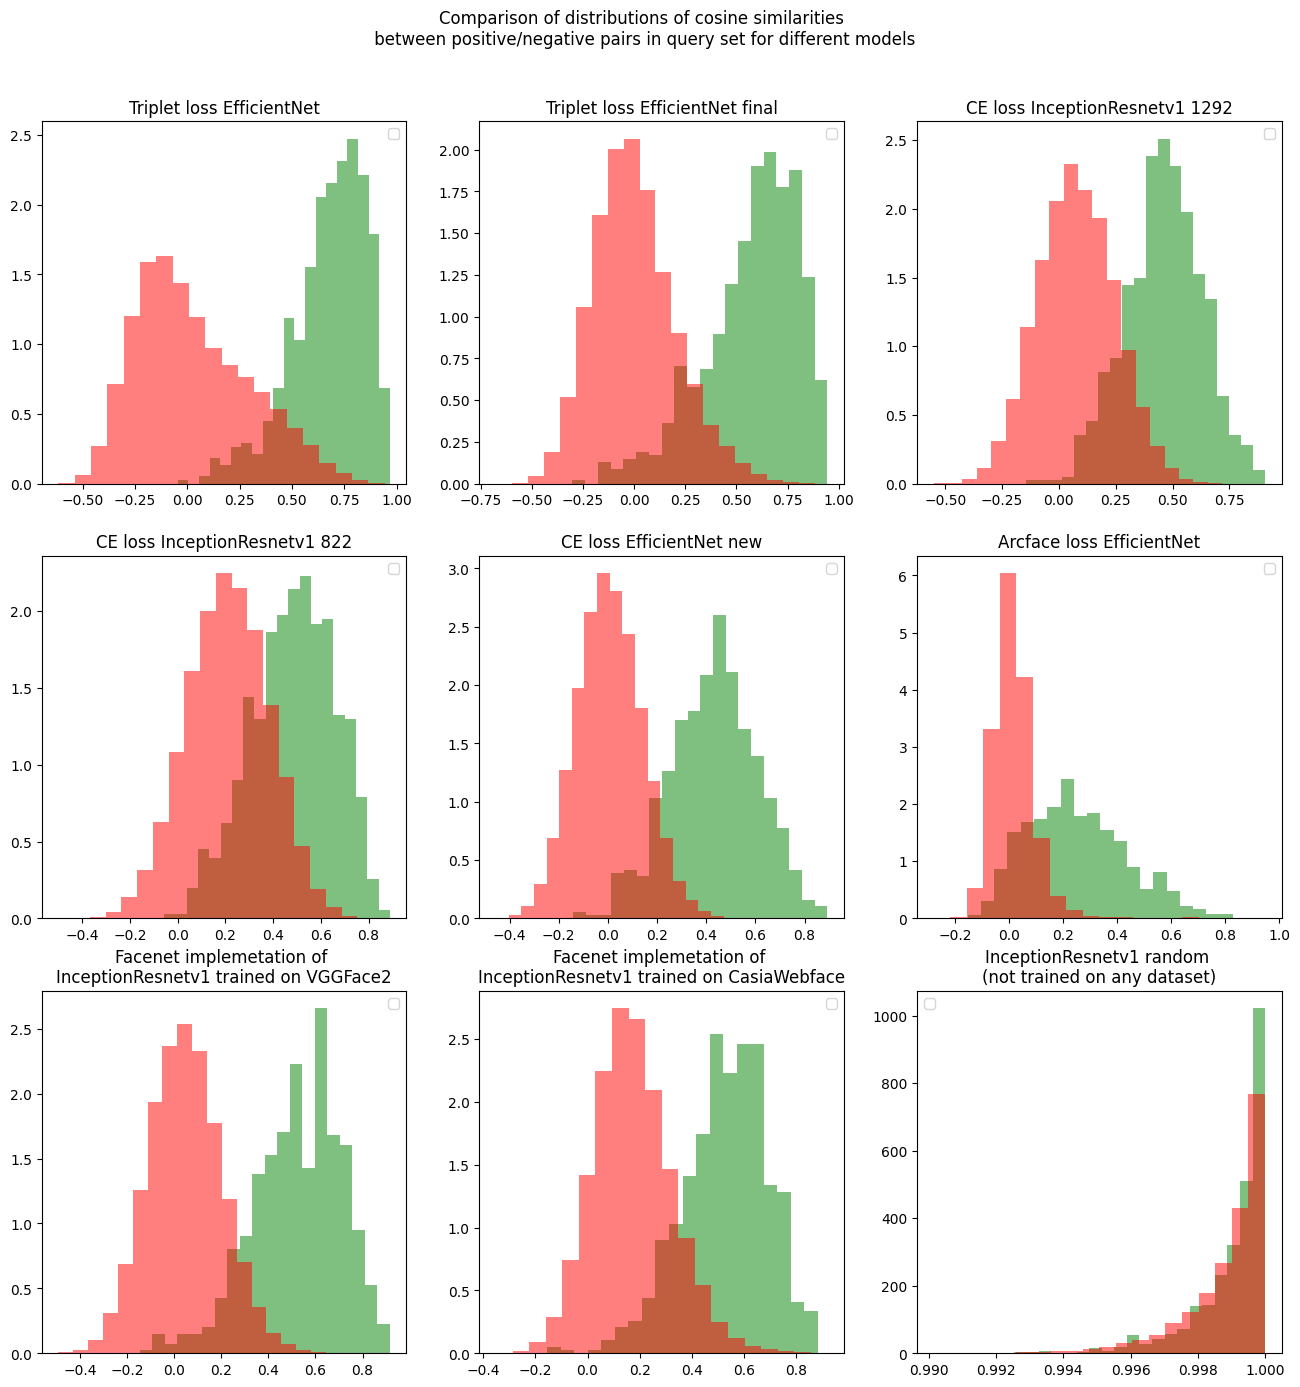

In [171]:
models_names = [
    'Triplet loss EfficientNet', 'Triplet loss EfficientNet final', 'CE loss InceptionResnetv1 1292', 
    'CE loss InceptionResnetv1 822', 'CE loss EfficientNet new', 'Arcface loss EfficientNet', 
    'Facenet implemetation of \nInceptionResnetv1 trained on VGGFace2', 
    'Facenet implemetation of \nInceptionResnetv1 trained on CasiaWebface', 
    'InceptionResnetv1 random \n(not trained on any dataset)'
]

fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()
# plt.figure(figsize=(16, 9))

for i, model_name in enumerate(models):
    query_embeddings = compute_embeddings(models[model_name], query_loader)
    
    cosine_query_pos = compute_cosine_query_pos(query_dict, queries_path, 
                                                query_embeddings)
    cosine_query_neg = compute_cosine_query_neg(query_dict, queries_path, 
                                                query_embeddings)

    axes[i].hist(cosine_query_pos, bins=20, color='green', histtype='barstacked', alpha=0.5, density=True) 
             #label=f'Distribution of cosine similarities\n between positive pairs in query set for model: {model_name}')
    axes[i].hist(cosine_query_neg, bins=20, color='red', histtype='barstacked', alpha=0.5, density=True)
            #label=f'Distribution of cosine similarities\n between negative pairs in query set for model: {model_name}')
    axes[i].set_title(models_names[i])
    axes[i].legend()
    
fig.suptitle('Comparison of distributions of cosine similarities\n between positive/negative pairs in query set for different models', y=0.95)
fig.savefig('1.png')
plt.show()

Let's plot distributions of cosine similarities between all pairs in query/distractor set

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

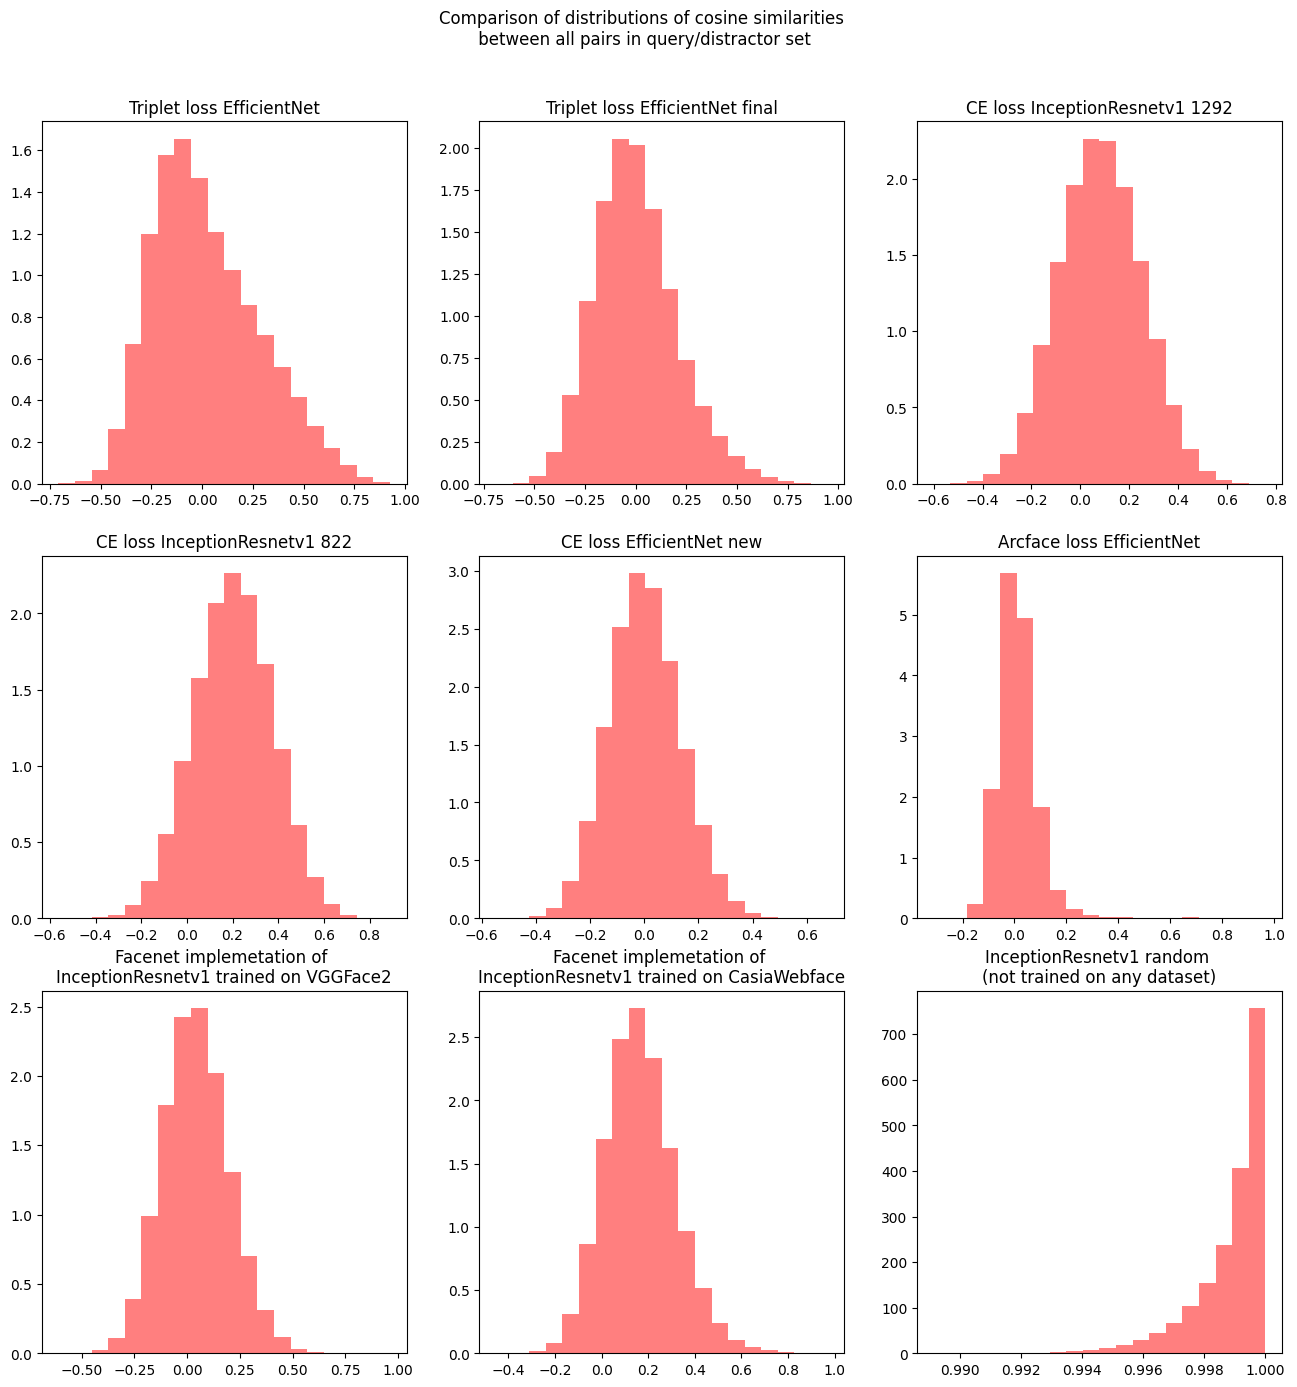

In [172]:
models_names = [
    'Triplet loss EfficientNet', 'Triplet loss EfficientNet final', 'CE loss InceptionResnetv1 1292', 
    'CE loss InceptionResnetv1 822', 'CE loss EfficientNet new', 'Arcface loss EfficientNet', 
    'Facenet implemetation of \nInceptionResnetv1 trained on VGGFace2', 
    'Facenet implemetation of \nInceptionResnetv1 trained on CasiaWebface', 
    'InceptionResnetv1 random \n(not trained on any dataset)'
]

fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flatten()
# plt.figure(figsize=(16, 9))

for i, model_name in enumerate(models):
    query_embeddings = compute_embeddings(models[model_name], query_loader)
    distractors_embeddings = compute_embeddings(models[model_name], distract_loader)
    
    cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)
    
    axes[i].hist(cosine_query_distractors, bins=20, color='red', histtype='barstacked', alpha=0.5, density=True)
    axes[i].set_title(models_names[i])
    
fig.suptitle(f'Comparison of distributions of cosine similarities\n between all pairs in query/distractor set', y=0.95)
fig.savefig('2.png')
plt.show()

Calculating ID rate for different FPRs

In [175]:
id_rate_dict = {}

for model_name in models:
    print(f'Calculating ID rate for model: {model_name}')
    tprs, fprs = compute_ir_for_model(models[model_name])
    id_rate_dict[model_name] = {}
    id_rate_dict[model_name]['fpr'] = fprs
    id_rate_dict[model_name]['tpr'] = tprs
    
    for tpr, fpr in zip(tprs, fprs):
        print(f'Identification rate (TPR@FPR={fpr:.3f}: {tpr:.4f})')
        
    print('')

Calculating ID rate for model: Triplet loss EfficientNet


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.9987)
Identification rate (TPR@FPR=0.250: 0.9827)
Identification rate (TPR@FPR=0.100: 0.9213)
Identification rate (TPR@FPR=0.050: 0.8280)
Identification rate (TPR@FPR=0.010: 0.5480)
Identification rate (TPR@FPR=0.005: 0.4307)
Identification rate (TPR@FPR=0.001: 0.2267)

Calculating ID rate for model: Triplet loss EfficientNet final


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.9800)
Identification rate (TPR@FPR=0.250: 0.9547)
Identification rate (TPR@FPR=0.100: 0.8787)
Identification rate (TPR@FPR=0.050: 0.8187)
Identification rate (TPR@FPR=0.010: 0.6120)
Identification rate (TPR@FPR=0.005: 0.5053)
Identification rate (TPR@FPR=0.001: 0.2933)

Calculating ID rate for model: CE loss InceptionResnetv1 1292


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.9867)
Identification rate (TPR@FPR=0.250: 0.9360)
Identification rate (TPR@FPR=0.100: 0.8253)
Identification rate (TPR@FPR=0.050: 0.7360)
Identification rate (TPR@FPR=0.010: 0.4960)
Identification rate (TPR@FPR=0.005: 0.4120)
Identification rate (TPR@FPR=0.001: 0.2507)

Calculating ID rate for model: CE loss InceptionResnetv1 822


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.9333)
Identification rate (TPR@FPR=0.250: 0.8080)
Identification rate (TPR@FPR=0.100: 0.6427)
Identification rate (TPR@FPR=0.050: 0.5280)
Identification rate (TPR@FPR=0.010: 0.2867)
Identification rate (TPR@FPR=0.005: 0.2240)
Identification rate (TPR@FPR=0.001: 0.1187)

Calculating ID rate for model: CE loss EfficientNet new


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.9947)
Identification rate (TPR@FPR=0.250: 0.9653)
Identification rate (TPR@FPR=0.100: 0.9333)
Identification rate (TPR@FPR=0.050: 0.8720)
Identification rate (TPR@FPR=0.010: 0.7240)
Identification rate (TPR@FPR=0.005: 0.6680)
Identification rate (TPR@FPR=0.001: 0.5160)

Calculating ID rate for model: Arcface loss EfficientNet


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.9227)
Identification rate (TPR@FPR=0.250: 0.8533)
Identification rate (TPR@FPR=0.100: 0.7640)
Identification rate (TPR@FPR=0.050: 0.7013)
Identification rate (TPR@FPR=0.010: 0.3293)
Identification rate (TPR@FPR=0.005: 0.0453)
Identification rate (TPR@FPR=0.001: 0.0000)

Calculating ID rate for model: Facenet implemetation of InceptionResnetv1 trained on VGGFace2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.9853)
Identification rate (TPR@FPR=0.250: 0.9680)
Identification rate (TPR@FPR=0.100: 0.9147)
Identification rate (TPR@FPR=0.050: 0.8773)
Identification rate (TPR@FPR=0.010: 0.7080)
Identification rate (TPR@FPR=0.005: 0.6453)
Identification rate (TPR@FPR=0.001: 0.4787)

Calculating ID rate for model: Facenet implemetation of InceptionResnetv1 trained on CasiaWebface


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.9787)
Identification rate (TPR@FPR=0.250: 0.9427)
Identification rate (TPR@FPR=0.100: 0.8427)
Identification rate (TPR@FPR=0.050: 0.7467)
Identification rate (TPR@FPR=0.010: 0.4307)
Identification rate (TPR@FPR=0.005: 0.2600)
Identification rate (TPR@FPR=0.001: 0.0427)

Calculating ID rate for model: InceptionResnetv1 random (not trained on any dataset)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Identification rate (TPR@FPR=0.500: 0.5613)
Identification rate (TPR@FPR=0.250: 0.3147)
Identification rate (TPR@FPR=0.100: 0.1413)
Identification rate (TPR@FPR=0.050: 0.0880)
Identification rate (TPR@FPR=0.010: 0.0227)
Identification rate (TPR@FPR=0.005: 0.0147)
Identification rate (TPR@FPR=0.001: 0.0040)



In [176]:
pd.set_option("display.precision", 4)

id_rate_df = pd.DataFrame({
    'tpr': [id_rate_dict[model_name]['tpr'] for model_name in models],
    'fpr': [id_rate_dict[model_name]['fpr'] for model_name in models],
}, index=models.keys())

In [177]:
id_rate_df.map(lambda lst: [round(elem, 3) for elem in lst])

,tpr,fpr
Triplet loss EfficientNet,"[0.999, 0.983, 0.921, 0.828, 0.548, 0.431, 0.227]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"
Triplet loss EfficientNet final,"[0.98, 0.955, 0.879, 0.819, 0.612, 0.505, 0.293]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"
CE loss InceptionResnetv1 1292,"[0.987, 0.936, 0.825, 0.736, 0.496, 0.412, 0.251]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"
CE loss InceptionResnetv1 822,"[0.933, 0.808, 0.643, 0.528, 0.287, 0.224, 0.119]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"
CE loss EfficientNet new,"[0.995, 0.965, 0.933, 0.872, 0.724, 0.668, 0.516]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"
Arcface loss EfficientNet,"[0.923, 0.853, 0.764, 0.701, 0.329, 0.045, 0.0]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"
Facenet implemetation of InceptionResnetv1 trained on VGGFace2,"[0.985, 0.968, 0.915, 0.877, 0.708, 0.645, 0.479]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"
Facenet implemetation of InceptionResnetv1 trained on CasiaWebface,"[0.979, 0.943, 0.843, 0.747, 0.431, 0.26, 0.043]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"
InceptionResnetv1 random (not trained on any dataset),"[0.561, 0.315, 0.141, 0.088, 0.023, 0.015, 0.004]","[0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]"


In [178]:
fprs = np.linspace(0, 1, 25, endpoint=False)

tprs_dict = {}
fprs_dict = {}

for model_name in models:
    tprs_model, fprs_model = compute_ir_for_model(models[model_name], fprs)
    tprs_dict[model_name] = tprs_model
    fprs_dict[model_name] = fprs_model

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

# Building ROC-curve

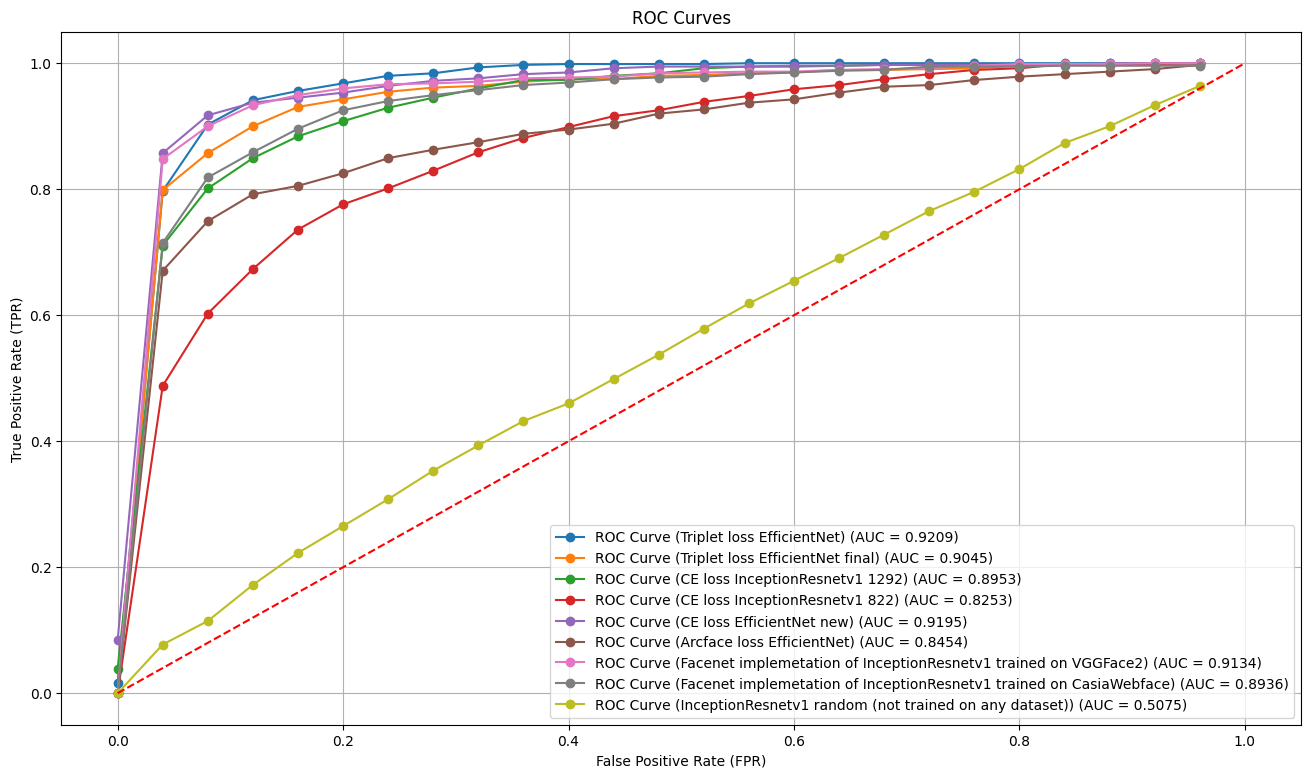

In [179]:
fprs = np.linspace(0, 1, 25, endpoint=False)
names = models.keys()

plt.figure(figsize=(16, 9))

for tprs, fprs, name in zip(list(tprs_dict.values()),
                            list(fprs_dict.values()),
                            names):
    
    auc = np.trapz(tprs, fprs)

    # Plot the ROC curve
    plt.plot(fprs, tprs, marker='o', label=f'ROC Curve ({name}) (AUC = {auc:.4f})')

# Add labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curves')
plt.grid(True)
plt.legend(loc='lower right')

# Add a diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='')

plt.savefig('roc_curves.png')
plt.show()

The best models is Triplet loss with EfficientNet as backbone